In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, BatchNormalization, Input, Activation, Dropout # type: ignore
import os
from sklearn.model_selection import train_test_split
import math
import read_data
import matplotlib.pyplot as plt

/Users/ilhamwisnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def conv_block(filters, strides):
    return Conv2D(filters=filters, kernel_size=3, strides=strides, activation='relu', padding='valid')

In [3]:
def eye_conv_blocks(inputs) :
    conv1 = conv_block(filters=64, strides=1)(inputs)
    conv2 = conv_block(filters=64, strides=2)(conv1)
    conv3 = conv_block(filters=128, strides=1)(conv2)
    conv4 = conv_block(filters=128, strides=2)(conv3)
    conv5 = conv_block(filters=256, strides=1)(conv4)
    conv6 = conv_block(filters=256, strides=2)(conv5)
    return conv6

In [4]:
def far_net() :
    # Aliran Pertama - Mata Kiri
    left_eye_input = Input(shape=(36,60,1))
    first_stream = eye_conv_blocks(left_eye_input)
    left_eye_features = Flatten()(first_stream)
    left_eye_features = Dense(500, activation='relu')(left_eye_features)
    
    # Aliran Kedua - Mata Kanan
    right_eye_input = Input(shape=(36,60,1))
    second_stream = eye_conv_blocks(right_eye_input)
    right_eye_features = Flatten()(second_stream)
    right_eye_features = Dense(500, activation='relu')(right_eye_features)

    # Aliran Ketiga - Wajah
    face_input = Input(shape=(224,224,3))
    face_features = Conv2D(96, kernel_size=(11,11), strides=(4,4))(face_input)
    face_features = BatchNormalization()(face_features)
    face_features = Activation("relu")(face_features)
    face_features = MaxPooling2D(pool_size=(3,3), strides=(2,2))(face_features)
    
    face_features = Conv2D(256, kernel_size=(5,5), padding='same')(face_features)
    face_features = BatchNormalization()(face_features)
    face_features = Activation("relu")(face_features)
    face_features = MaxPooling2D(pool_size=(3,3), strides=(2,2))(face_features)
    
    face_features = Conv2D(384, kernel_size=(3,3), padding='same')(face_features)
    face_features = BatchNormalization()(face_features)
    face_features = Activation("relu")(face_features)
    face_features = Conv2D(384, kernel_size=(3,3), padding='same')(face_features)
    face_features = BatchNormalization()(face_features)
    face_features = Activation("relu")(face_features)
    face_features = Conv2D(256, kernel_size=(3,3), padding='same')(face_features)
    face_features = BatchNormalization()(face_features)
    face_features = Activation("relu")(face_features)
    face_features = MaxPooling2D(pool_size=(3,3), strides=(2,2))(face_features)
    
    face_features = Flatten()(face_features)
    face_features = Dense(4096, activation='relu')(face_features)
    face_features = Dropout(0.5)(face_features)
    face_features = Dense(4096, activation='relu')(face_features)
    face_features = Dropout(0.5)(face_features)
    face_features = Dense(500, activation='relu')(face_features)
    
    #Penggabungan Fitur
    concatenated_features = Concatenate()([left_eye_features,right_eye_features, face_features])
    outputs = Dense(6)(concatenated_features)
    
    model = keras.Model(inputs=[left_eye_input,right_eye_input,face_input], outputs=outputs)
    
    return model

In [5]:
def e_net():
    
    # Aliran Pertama - Mata Kiri
    left_eye_input = Input(shape=(36,60,1))
    first_stream = eye_conv_blocks(left_eye_input)
    left_eye_features = Flatten()(first_stream)
    left_eye_features = Dense(1000, activation='relu')(left_eye_features)
    left_eye_features = Dense(500, activation='relu')(left_eye_features)
    
    # Aliran Kedua - Mata Kanan
    right_eye_input = Input(shape=(36,60,1))
    second_stream = eye_conv_blocks(right_eye_input)
    right_eye_features = Flatten()(second_stream)
    right_eye_features = Dense(1000, activation='relu')(right_eye_features)
    right_eye_features = Dense(500, activation='relu')(right_eye_features)
    
    concatenated_features = Concatenate()([left_eye_features,right_eye_features])
    output = Dense(2, activation='softmax')(concatenated_features)
    
    model = keras.Model(inputs=[left_eye_input, right_eye_input], outputs=output)
    
    return model


In [6]:
def split_into_batches(data, batch_size):
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batches.append(zip(*batch))
    return batches

In [7]:
def angular_err(v1, v2):
	v1xv2 = tf.reduce_sum(v1*v2,1)
	v1_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v1), 1)),dtype=tf.float32)
	v2_len = tf.cast(tf.sqrt(tf.reduce_sum(tf.square(v2), 1)),dtype=tf.float32)
	
	val = v1xv2/((v1_len* v2_len ) + 1e-10)
 
	degree = tf.acos(val)
	return degree * 180/ math.pi

In [8]:
def fare_loss(left_err, right_err, probs):
    
            
    far_err = ((2 * left_err * right_err ) + 1e-10)  / ((left_err + right_err) + 1e-10)
    # print(f"FAR-err -> {far_err}")
    
    avg_err = (left_err + right_err) /2
    
    n = tf.cast(tf.less_equal(left_err, right_err), tf.float32)
    
    # print(f"N -> {n}")
    
    squared_distance = tf.reduce_sum(tf.square(left_err - right_err), axis=-1)
    
    e_loss = - (n * squared_distance * tf.math.log(probs[:,0]) + (1 - n) * squared_distance * tf.math.log(probs[:,1]))
    
    weight = (1 + (2 * n - 1) * probs[:,0] + (1 - 2 * n) * probs[:,1]) / 2
    
    # print(f"W --> {weight}")
    
    far_loss = weight * far_err + (1 - weight) * 0.1 * avg_err
    
    return far_loss, e_loss

In [9]:
def train(ds_train, ds_test, batch_size=100, epochs=1, dataset_type='original') :
    
    ds_train = list(zip(ds_train[0],ds_train[1],ds_train[2],ds_train[3]))
    ds_test = list(zip(ds_test[0],ds_test[1],ds_test[2],ds_test[3]))
    
    far_net_model = far_net()
    e_net_model = e_net()
    
    far_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    e_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    
    train_far_loss_metric = tf.keras.metrics.Mean(name='train_far_loss')
    train_e_loss_metric = tf.keras.metrics.Mean(name='train_e_loss')
    train_angular_error_metric = tf.keras.metrics.Mean(name='train_angular_error')
    train_probability_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_probability_accuracy')
    
    test_far_loss_metric = tf.keras.metrics.Mean(name='test_far_loss')
    test_e_loss_metric = tf.keras.metrics.Mean(name='test_e_loss')
    test_angular_error_metric = tf.keras.metrics.Mean(name='test_angular_error')
    test_probability_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_probability_accuracy')
    
    train_far_losses = []
    train_e_losses = []
    train_choose_accs = []
    train_angular_errs = []
    
    test_far_losses = []
    test_e_losses = []
    test_choose_accs = []
    test_angular_errs = []
    
    
    def train_step(l_eyes, r_eyes, faces, labels):
        with tf.GradientTape() as far_tape, tf.GradientTape() as e_tape :
                
            gaze_preds = far_net_model([l_eyes, r_eyes, faces], training=True)
            probs = e_net_model([l_eyes, r_eyes], training=True)
                        
            # print(f"Gaze  --> {gaze_preds[:,:3]}")
            # print(f"Label --> {labels[:,:3]}")
            # print(f"Gaze  --> {gaze_preds[:,3:]}")
            # print(f"Label --> {labels[:,3:]}")
            
            left_err = angular_err(gaze_preds[:,:3],labels[:,:3])
            right_err = angular_err(gaze_preds[:,3:],labels[:,3:])
            
            # print(f"Left Err --> {left_err}")
            # print(f"Right Err --> {right_err}")
            
            far_loss, e_loss = fare_loss(left_err, right_err, probs)
            print(f"FAR loss --> {tf.reduce_mean(far_loss)}")
            print(f"E loss --> {tf.reduce_mean(e_loss)}")
            
        gradients1 = far_tape.gradient(far_loss, far_net_model.trainable_variables)
        gradients2 = e_tape.gradient(e_loss, e_net_model.trainable_variables)
            
        # print(f"GRAD --> {gradients1}")
        # print(f"GRAD --> {gradients2}")
        
        far_optimizer.apply_gradients(zip(gradients1, far_net_model.trainable_variables))
        e_optimizer.apply_gradients(zip(gradients2, e_net_model.trainable_variables))
        
        choose_preds = tf.cast(tf.less_equal(probs[:,0], probs[:,1]), tf.int16) 
        choose_labels = tf.cast(tf.greater_equal(left_err, right_err), tf.int16)
        
        angular_errors = [ left_err[i] if i == 0 else right_err[i] for i in choose_preds ]
        
        train_far_loss_metric(far_loss)
        train_e_loss_metric(e_loss)
        train_angular_error_metric(angular_errors)
        train_probability_accuracy(choose_labels, choose_preds)
    
    def test_step(l_eyes, r_eyes, faces, labels):
        gaze_preds = far_net_model([l_eyes, r_eyes, faces], training=False)
        probs = e_net_model([l_eyes, r_eyes], training=False)
        
        # print(f"Gaze  --> {gaze_preds[:,:3]}")
        # print(f"Label --> {labels[:,:3]}")
        # print(f"Gaze  --> {gaze_preds[:,3:]}")
        # print(f"Label --> {labels[:,3:]}")
        
        left_err = angular_err(gaze_preds[:,:3],labels[:,:3])
        right_err = angular_err(gaze_preds[:,3:],labels[:,3:])
        
        # print(f"Left Err --> {left_err}")
        # print(f"Right Err --> {right_err}")
        
        far_loss, e_loss = fare_loss(left_err, right_err, probs)
        
        choose_preds = tf.cast(tf.less_equal(probs[:,0], probs[:,1]), tf.int16) 
        choose_labels = tf.cast(tf.greater_equal(left_err, right_err), tf.int16)
        
        angular_errors = [ left_err[i] if i == 0 else right_err[i] for i in choose_preds ]
        
        test_far_loss_metric(far_loss)
        test_e_loss_metric(e_loss)
        test_angular_error_metric(angular_errors)
        test_probability_accuracy(choose_labels, choose_preds)
    
    for epoch in range(1,epochs + 1) :
        print(f"Epoch {epoch} -- START")
        
        train_far_loss_metric.reset_state()
        train_e_loss_metric.reset_state()
        train_angular_error_metric.reset_state()
        train_probability_accuracy.reset_state()
        
        test_far_loss_metric.reset_state()
        test_e_loss_metric.reset_state()
        test_angular_error_metric.reset_state()
        test_probability_accuracy.reset_state()
        
        
        for l_eyes, r_eyes, faces, labels in split_into_batches(ds_train,batch_size) :
            l_eyes, r_eyes, faces, labels = np.array(l_eyes), np.array(r_eyes), np.array(faces), np.array(labels)
            train_step(l_eyes, r_eyes, faces, labels)

        for l_eyes, r_eyes, faces, labels in split_into_batches(ds_test,batch_size) :
            l_eyes, r_eyes, faces, labels = np.array(l_eyes), np.array(r_eyes), np.array(faces), np.array(labels)
            test_step(l_eyes, r_eyes, faces, labels)
            
        print(f"Epoch {epoch} -- END")
        print("\n Training")
        print(f"FAR-Loss: {train_far_loss_metric.result()}")   
        print(f"E-Loss: {train_e_loss_metric.result()}")   
        print(f"Reliability Accuracy: {train_probability_accuracy.result() * 100}%")   
        print(f"Angular Error: {train_angular_error_metric.result()}")  
        print("\n Validation")
        print(f"FAR-Loss: {test_far_loss_metric.result()}")   
        print(f"E-Loss: {test_e_loss_metric.result()}")   
        print(f"Reliability Accuracy: {test_probability_accuracy.result() * 100}%")   
        print(f"Angular Error: {test_angular_error_metric.result()}")  
        
        train_far_losses.append(train_far_loss_metric.result()) 
        train_e_losses.append(train_e_loss_metric.result()) 
        train_choose_accs.append(train_probability_accuracy.result()) 
        train_angular_errs.append(train_angular_error_metric.result()) 
        
        test_far_losses.append(test_far_loss_metric.result()) 
        test_e_losses.append(test_e_loss_metric.result()) 
        test_choose_accs.append(test_probability_accuracy.result()) 
        test_angular_errs.append(test_angular_error_metric.result()) 

    
    
    save_path = f"log/{ dataset_type }/{epochs}"

    if not os.path.exists(save_path) :
        os.makedirs(save_path, exist_ok=True)
        
    far_net_model.save(f"{save_path}/far_net_model.keras")
    e_net_model.save(f"{save_path}/e_net_model.keras")
    print(f"Model Saved at {save_path}")
    
    return train_far_losses, train_e_losses, train_angular_errs, train_choose_accs, test_far_losses, test_e_losses, test_angular_errs, test_choose_accs

In [10]:
dataset_type = "enhanced2"
epochs = 1

In [11]:
l_eye_images, r_eye_images, face_images, labels = read_data.load_dataset(dataset_type=dataset_type)

l_eye_train, l_eye_test, r_eye_train, r_eye_test, face_train, face_test, labels_train, labels_test = train_test_split(
    l_eye_images, r_eye_images, face_images, labels, test_size=0.2, random_state=42)

# Check the shapes of the train and test sets
print("Left eye train shape:", l_eye_train.shape)
print("Right eye train shape:", r_eye_train.shape)
print("Face train shape:", face_train.shape)
print("Labels train shape:", labels_train.shape)

print("Left eye test shape:", l_eye_test.shape)
print("Right eye test shape:", r_eye_test.shape)
print("Face test shape:", face_test.shape)
print("Labels test shape:", labels_test.shape)

Reading => data_subset/enhanced2/p14
Left eye train shape: (800, 36, 60)
Right eye train shape: (800, 36, 60)
Face train shape: (800, 224, 224, 3)
Labels train shape: (800, 6)
Left eye test shape: (200, 36, 60)
Right eye test shape: (200, 36, 60)
Face test shape: (200, 224, 224, 3)
Labels test shape: (200, 6)


In [12]:
train_far_losses, train_e_losses, train_angular_errs, train_choose_accs, test_far_losses, test_e_losses, test_angular_errs, test_choose_accs =  train(ds_train=[l_eye_train, r_eye_train, face_train, labels_train], ds_test=[l_eye_test, r_eye_test, face_test, labels_test], epochs=epochs, dataset_type=dataset_type)

Epoch 1 -- START
FAR loss --> 53.932106018066406
E loss --> 192674.203125
FAR loss --> 16.284317016601562
E loss --> 5545.01611328125
FAR loss --> 7.04856014251709
E loss --> 1654.6541748046875
FAR loss --> 10.941850662231445
E loss --> 2517.393310546875
FAR loss --> 6.869205951690674
E loss --> 2946.888671875
FAR loss --> 5.958436489105225
E loss --> 3199.141845703125
FAR loss --> 5.753142833709717
E loss --> 2537.191162109375
FAR loss --> 5.040961742401123
E loss --> 2693.119384765625
Epoch 1 -- END

 Training
FAR-Loss: 13.9785737991333
E-Loss: 26720.953125
Reliability Accuracy: 62.625003814697266%
Angular Error: 21.2852840423584

 Validation
FAR-Loss: 5.530336380004883
E-Loss: 3363.432861328125
Reliability Accuracy: 56.0%
Angular Error: 6.1861958503723145
Model Saved at log/enhanced2/1


In [16]:
def visualize_result(epochs, train_result, test_result, y_label, my) :
    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, train_result, label=f"Training {y_label} ")
    plt.plot(epochs_range, test_result, label=f'Validation {y_label}')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend(loc='upper right')
    # plt.xlim(0,mx)
    plt.ylim(0,my)
    plt.title(f'Training and Validation {y_label}')

Image saved at log/enhanced2/1


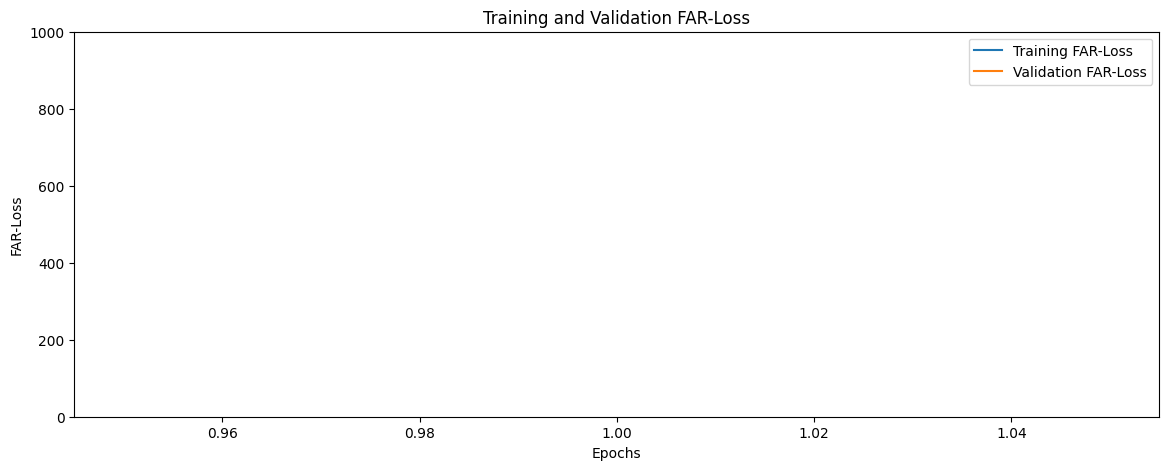

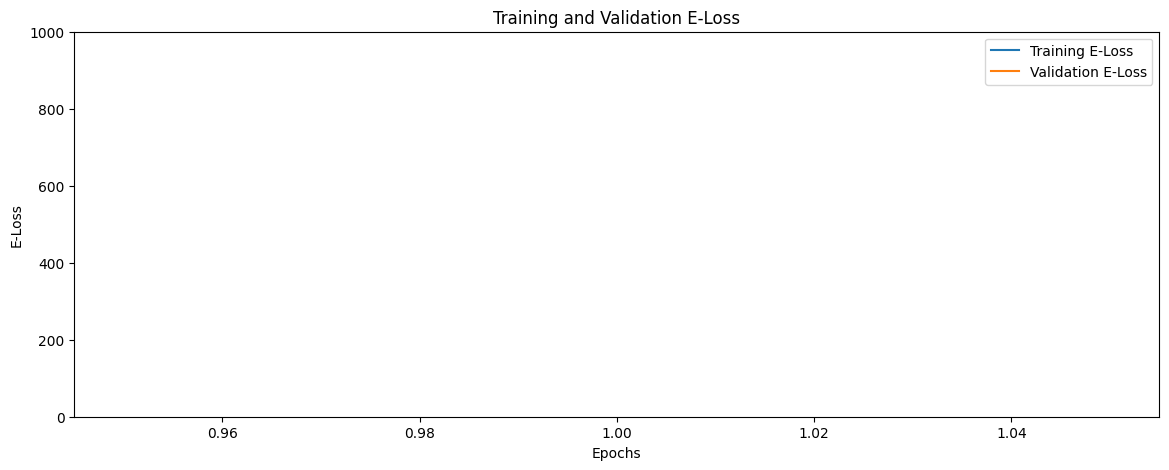

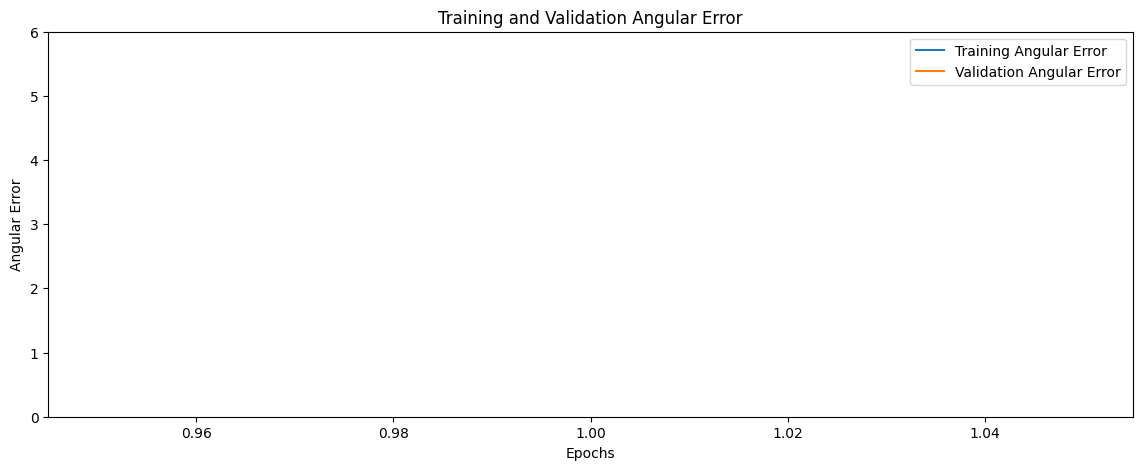

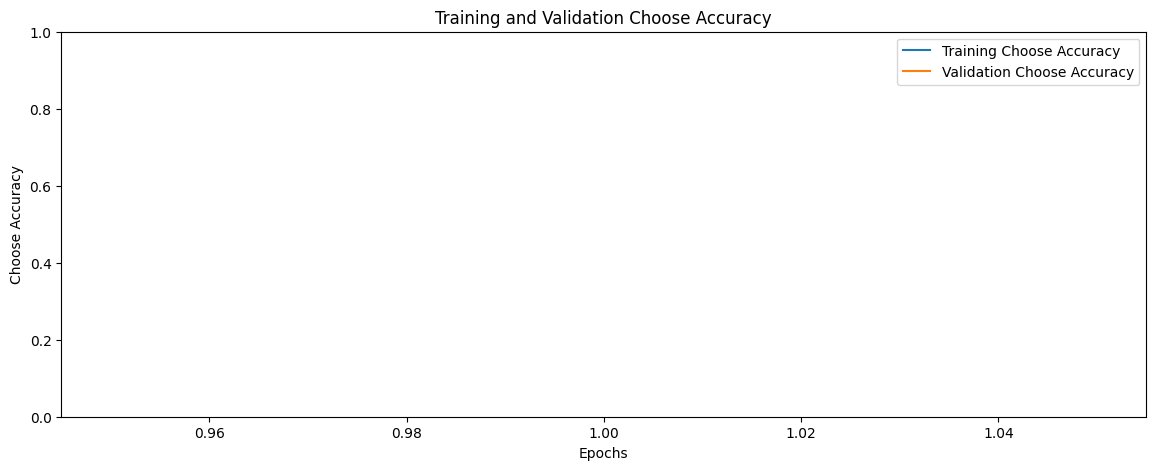

In [17]:

data_type = dataset_type
save_path = f"log/{ data_type }/{epochs}"

if not os.path.exists(save_path) :
     os.makedirs(save_path, exist_ok=True)

plt.figure(figsize=(14, 5))    
visualize_result(epochs=epochs, train_result=train_far_losses , test_result= test_e_losses, y_label="FAR-Loss", my=1000 )
plt.savefig(f"{save_path}/far-loss.jpg")
plt.figure(figsize=(14, 5))    
visualize_result(epochs=epochs, train_result=train_e_losses , test_result= test_e_losses, y_label="E-Loss", my=1000)
plt.savefig(f"{save_path}/e-loss.jpg")
plt.figure(figsize=(14, 5))    
visualize_result(epochs=epochs, train_result=train_angular_errs , test_result=test_angular_errs, y_label="Angular Error", my=6)
plt.savefig(f"{save_path}/angular-error.jpg")
plt.figure(figsize=(14, 5))    
visualize_result(epochs=epochs, train_result=train_choose_accs , test_result=test_choose_accs, y_label="Choose Accuracy", my=1)
plt.savefig(f"{save_path}/choose-accuracy.jpg")

print(f"Image saved at {save_path}")